<a href="https://colab.research.google.com/github/luizgdev/Rede-Neural-Convolucional-gatos-e-cachorros-/blob/main/Rede_Neural_Convolucional_Classifica%C3%A7%C3%A3o_de_Imagens.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introdução**

Uma Rede Neural Convolucional (CNN), também conhecida como ConvNet, é um tipo de arquitetura de rede neural projetada especialmente para o processamento de dados de grade, como imagens. Essa arquitetura é particularmente eficaz em tarefas de visão computacional, como classificação de imagens, detecção de objetos e reconhecimento de padrões.

# **Dados de Imagem**

Dados podem ter várias dimensões diferentes, as imgens que nós escolhemos tem 3 dimensões, que são:

*   Altura
*   Largura
*   Canais de cor

A altura e largura são dadas em pixels, já os canais de cor representam a profundidade da imagem e sinalizam as cores usadas. Um exemplo são imagens RGB (red, green and blue), que tem 3 canais, cada um pixels com valores num intervalo de 0 até 255. Uma imagem com 1 canal seria em tons de cinza e também teria pixels com valores indo de 0 até 255.

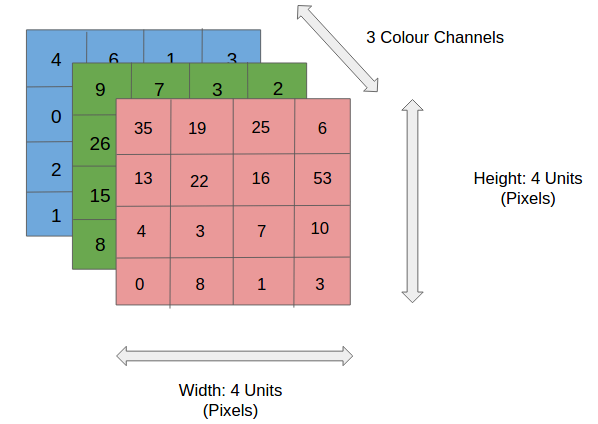

#Mapa de características
Este termo significa simplesmente um tensor 3D com dois eixos espaciais (largura e altura) e um eixo de profundidade. Nossas camadas convolucionais tomam mapas de características como entrada e retornam um novo mapa de características que representa a presença de filtros específicos do mapa de características anterior. Isso é o que chamamos de mapas de resposta.

#Parametros de camada
Uma camada convolucional é definida por dois parâmetros chave.

###Filtros
Um filtro é um padrão m x n de pixels que procuramos em uma imagem. O número de filtros em uma camada convolucional representa quantos padrões cada camada está procurando e qual será a profundidade do nosso mapa de resposta. Se estivermos procurando por 32 padrões/filtros diferentes, nosso mapa de recursos de saída (também conhecido como mapa de resposta) terá uma profundidade de 32. Cada uma das 32 camadas de profundidade será uma matriz de algum tamanho contendo valores indicando se o filtro foi presente naquele local ou não.

Aqui está um exemplo de filtro:
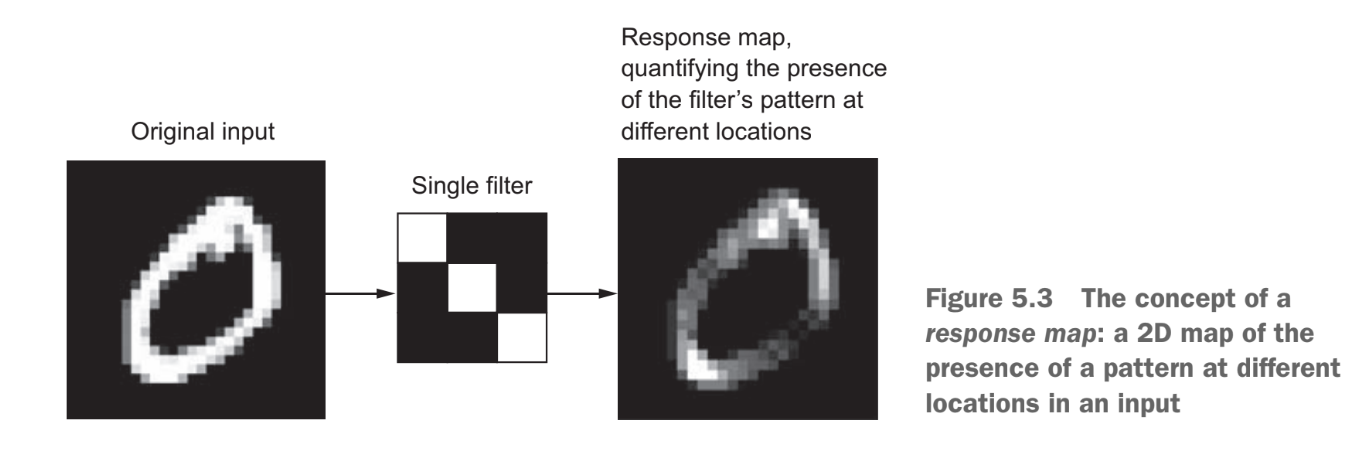

###Tamanho da amostra
Cada camada convolucional examinará n x m blocos de pixels em cada imagem. Normalmente, consideraremos blocos 3x3 ou 5x5. No exemplo acima usamos um “tamanho de amostra” 3x3. Este tamanho será igual ao tamanho do nosso filtro.

Nossas camadas funcionam deslizando esses filtros de n x m pixels sobre cada posição possível em nossa imagem e preenchendo um novo mapa de recursos/mapa de resposta indicando se o filtro está presente em cada local.


#Bordas e Preenchimento
Se deslizarmos um filtro de, digamos, tamanho 3x3 sobre nossa imagem, consideraremos menos posições para nosso filtro do que pixels em nossa entrada. Veja o exemplo abaixo.

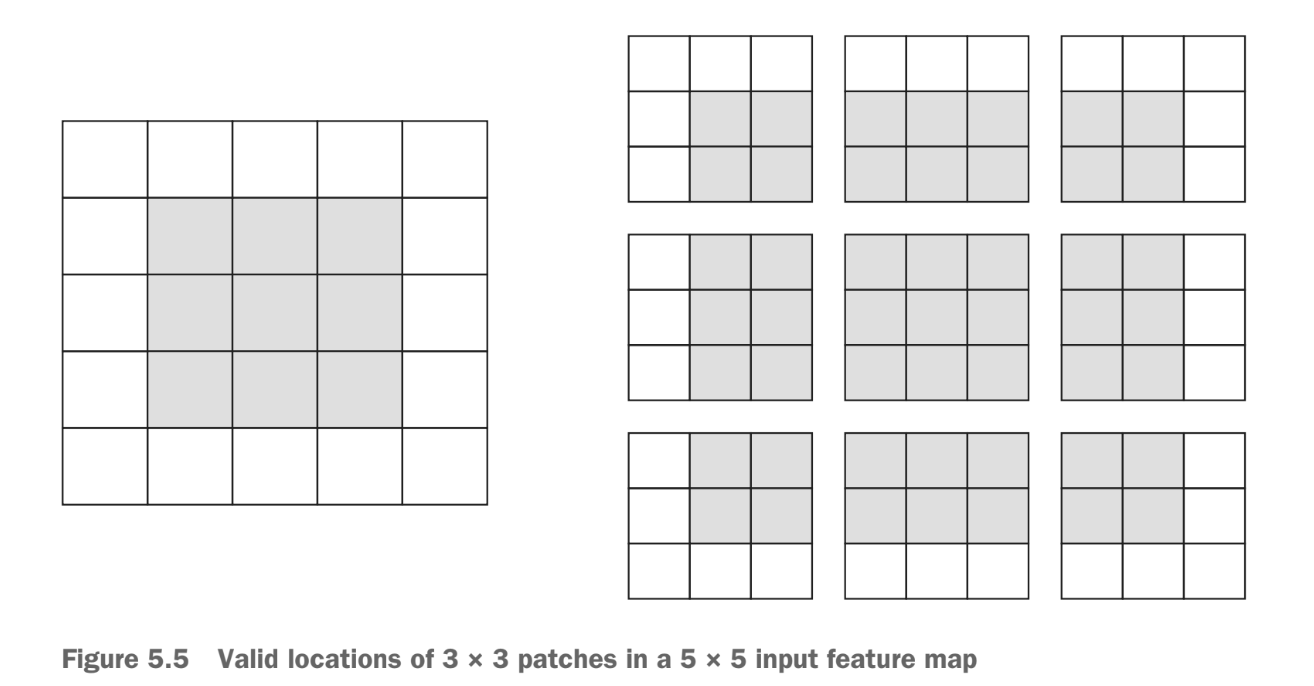

Isso significa que nosso mapa de resposta terá largura e altura ligeiramente menores do que nossa imagem original. Tudo bem, mas às vezes queremos que nosso mapa de respostas tenha as mesmas dimensões. Podemos fazer isso usando algo chamado *preenchimento*.

O **preenchimento** é simplesmente a adição do número apropriado de linhas e/ou colunas aos seus dados de entrada, de modo que cada pixel possa ser centralizado pelo filtro.


#Pooling
Redes neurais convolucionais são compostas de uma pilha de camadas de convolução e pooling.

A ideia por trás de uma camada de pooling é reduzir a resolução de nossos mapas de recursos e reduzir suas dimensões. Eles funcionam de maneira semelhante às camadas convolucionais, onde extraem janelas do mapa de características e retornam um mapa de resposta dos valores máximo, mínimo ou médio de cada canal. O agrupamento geralmente é feito usando janelas de tamanho 2x2 e passo 2. Isso reduzirá o tamanho do mapa de recursos por um fator de dois e retornará um mapa de resposta 2x menor.

# Imports
### TensorFlow
É uma biblioteca de código aberto para aprendizado de máquina aplicável a uma ampla variedade de tarefas.

### Keras
É uma biblioteca de código aberto baseada no TensorFlow, criada para Deep Learning. Ele é utilizado na criação de redes neurais para resolução de várias tarefas diferentes, como classificação de imagens, detecção de objetos e regressão.

### NumPy
É uma biblioteca que suporta o processamento de grandes, multi-dimensionais arranjos e matrizes, juntamente com uma grande coleção de funções matemáticas de alto nível para operar sobre estas matrizes.

### Matplotlib
É uma biblioteca de software para criação de gráficos e visualizações de dados em geral.

### OS
É um módulo que permite interagir com o sistema operacional.

In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
keras = tf.keras

#Importando e dividindo o dataset
Vamos utilizar o dataset [cats_vs_dogs](https://www.tensorflow.org/datasets/catalog/cats_vs_dogs?hl=pt-br) (gatos ou cachorros), que é um conjunto de dados grande contendo apenas imagens desses dois animais.

Vamos dividir esse conjunto de dados da seguinte forma:
- 80% das imagens serão usadas para treino.
- 10% das imagens serão usadas para validação.
- 10% das imagens serão usadas para testar o modelo final.

Sendo 18.610 imagens para treino, 2.326 imgens para validação e para o teste, totalizando em 23.262 imagens.

In [5]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar() # Desativa a barra de progresso no momento de importar os dados.

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True, # Importa os dados com informações adicionais (metadados).
    as_supervised=True, # Importa os dados em formato de tupla (imagem, rótulo).
)

#Exemplos
A seguir temos 2 exemplos de imagens do dataset.

Como os rótulos são armazenados em Inteiros, sendo o valor 0 para gato e 1 para cachorro, precisamos fazer a função **get_label_name**, que converte esses rótulos para seus respectivos nomes.

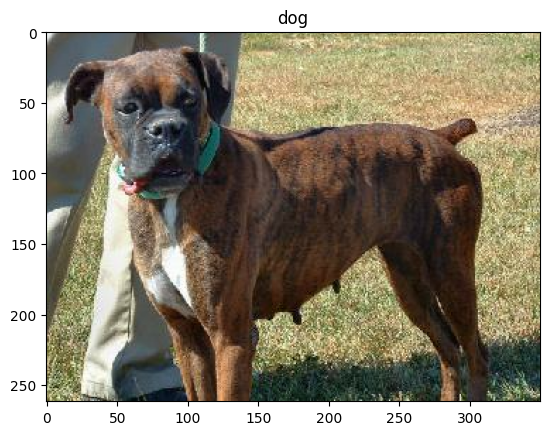

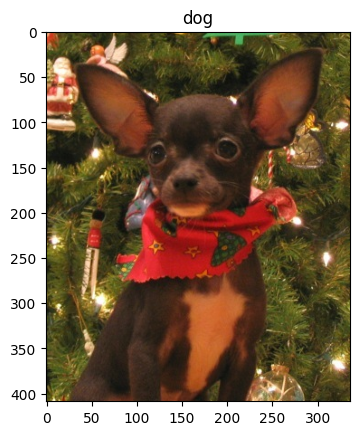

In [6]:
get_label_name = metadata.features['label'].int2str  # Função para pegar o nome do rótulo.

for image, label in raw_train.take(2):
  plt.figure() # Cria uma figura.
  plt.imshow(image) # Exibe a imagem.
  plt.title(get_label_name(label)) # Exibe o título (rótulo).

#Normalizando as imagens
Para que o nosso modelo funcione, é preciso que as imagens estejam todas no mesmo tamanho. Isso se chama normalização de dados, vamos diminuir o tamanho das imagens para 160x160 pixels, assim os detalhes serão mantidos.

Além disso os valores do pixels serão normalizados entre -1 e 1. Isso ajuda na convergência do modelo.

In [7]:
IMG_SIZE = 160

def format_example(image, label):
  image = tf.cast(image, tf.float32) # Converte cada pixel para um valor float.
  image = (image/127.5) - 1 # Normaliza os valores dos pixels para o intervalo de [-1,1].
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE)) # Redimensiona a imagem.
  return image, label

# Aplicando a função no dataset

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

# Exemplos normalizados

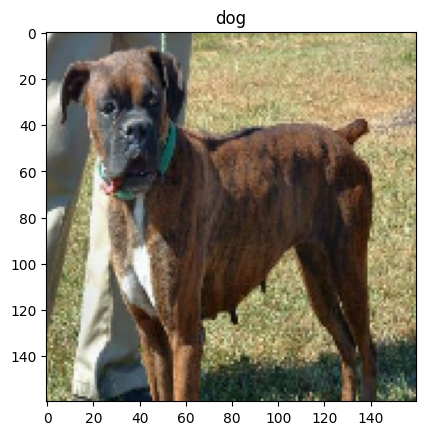

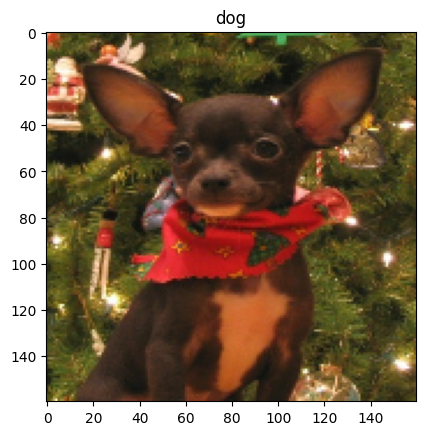

In [11]:
for image, label in train.take(2):
  image = (image + 1) * 127.5 # Inverte a normalização.
  image = np.round(image).astype(np.uint8) # Converte os valores dos pixels para Inteiro.
  plt.figure()
  plt.imshow(image)
  plt.title(get_label_name(label))

# Organizando os dados para o treino
Antes de treinar é preciso organizar as imagens em lotes (batches).

Cada lote terá 32 imagens e foi definido que o buffer responsável por criar esses batches tem tamanho 1000, ou seja, mil amostras serão embaralhadas antes de criar cada lote.

In [13]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

# Definindo os batches.
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

#Comparando shapes
Cada Tensor tem o seu shape, que é o formato em que ele se encontra. No nosso caso o shape é um vetor contendo a altura, largura e o número de dimensões da imagem.

In [17]:
for img, label in raw_train.take(2):
  print("Shape:inicial", img.shape)

for img, label in train.take(2):
  print("Shape normalizado:", img.shape)

Shape:inicial (262, 350, 3)
Shape:inicial (409, 336, 3)
Shape normalizado: (160, 160, 3)
Shape normalizado: (160, 160, 3)


#Criando o modelo base
Vamos utilizar um modelo pré-treinado para ajudar a extrair características das nossas imagens. Para isso vamos usar o [MobileNet V2](https://keras.io/api/applications/mobilenet/).

In [18]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, # Cada imagem terá o shape definido.
                                               include_top=False, # Não inclui a camada de classificação do ImageNet.
                                               weights='imagenet') # Define que os pesos já treinados do ImageNet sejam usados.

9406464/9406464 [==============================] - 0s 0us/step


# Sumário do ImageNet

In [ ]:
base_model.summary()

#Congelando os pesos do modelo
Para realizar a transferência de conhecimento do ImageNetV2 para o nosso modelo, é preciso congelar os pesos do modelo que já foi treinado.

In [34]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 160, 160, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 80, 80, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 80, 80, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 80, 80, 32)           0         ['bn_Conv1[

#Pooling
Agora vamos usar uma camada de pooling que realiza uma média global dos valores em cada canal da entrada. Em termos simples, ela substitui cada mapa de características (feature map) por sua média global. Isso reduz a resolução espacial dos mapas de características, mantendo o número de canais.

In [35]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

# Criando uma camada densa
Vamos criar uma camada densa (fully connected) que será usada para gerar as previsões finais do nosso modelo. Ela vai conectar o nosso modelo com o ImageNet.

In [36]:
prediction_layer = keras.layers.Dense(1) # O valor 1 indica que haverá um valor de saída.

# Criando o modelo final
Agora vamos criar nosso modelo, usando o modelo de base (ImageNetV2), a camada de pooling e a camada de previsão.

In [37]:
model = tf.keras.Sequential([
  base_model,
  global_average_layer,
  prediction_layer
])

#Sumário do modelo final

In [38]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense_4 (Dense)             (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


# Compilando o modelo
Agora chegou a hora de compilar o modelo, para isso vamos definir que a taxa de aprendizado (base_learning_rate) será de 0.0001 e vamos passar parâmetros para o compilador do modelo.

O **RMSprop** é um otimizador popular que adapta a taxa de aprendizado individualmente para cada parâmetro.

**BinaryCrossentropy** configura a função de perda e é comumente usada em tarefas de classificação binária. O parâmetro **from_logits=True** indica que as previsões do modelo não passaram por uma função de ativação (como sigmoid) e são consideradas logits.

**Metrics** é a métrica de avaliação do modelo escolhida é a precisão, que é uma métrica comum para tarefas de classificação.

In [39]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Avaliando o desempenho
Para avaliar o desempenho vamos passar pelos dados de treinamento 3 vezes (3 epochs) e usar 20 batches.

In [43]:
initial_epochs = 3
validation_steps=20

loss0,accuracy0 = model.evaluate(validation_batches, steps = validation_steps)

20/20 [==============================] - 11s 531ms/step - loss: 0.7332 - accuracy: 0.5297


comentar da loss e da accuracy

#Treinamento
Finalmente chegou o momento de treinar o modelo. Para isso vamos usar os batches de treino, o mesmo número de epochs de antes e dados para validar o nosso modelo enquanto ele é treinado.

In [44]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

acc = history.history['accuracy'] # Pega a acurácia de cada epoch.
print(acc)

Epoch 1/3
582/582 [==============================] - 347s 588ms/step - loss: 0.0693 - accuracy: 0.9742 - val_loss: 0.0455 - val_accuracy: 0.9819
Epoch 2/3
582/582 [==============================] - 338s 578ms/step - loss: 0.0439 - accuracy: 0.9838 - val_loss: 0.0427 - val_accuracy: 0.9841
Epoch 3/3
582/582 [==============================] - 341s 582ms/step - loss: 0.0396 - accuracy: 0.9854 - val_loss: 0.0413 - val_accuracy: 0.9841
[0.9741536974906921, 0.9838259220123291, 0.9853842258453369]


#Salvando o modelo

In [51]:
model.save("caes_e_gatos.keras")  # Salvando o modelo.
new_model = tf.keras.models.load_model('caes_e_gatos.keras') # Carregando o modelo.

#Demonstração

1/1 [==============================] - 0s 44ms/step

Index: 693 de 2326 imagens.

Predição crua (raw prediction): -15.68.

Predição normalizada com tangente hiperbólica (tanh): -1.00.

Chance de ser gato: 100.00%.



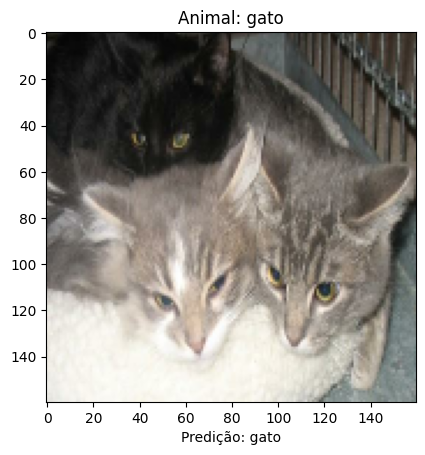

In [88]:
import random
from scipy.special import expit

def predict(model, image, correct_label):
  class_names = ['gato','cachorro']
  prediction = model.predict(np.array([image]))
  raw_prediction = float(prediction)
  tanh = np.tanh(raw_prediction)

  print(f"\nIndex: {num} de 2326 imagens.\n")
  print(f"Predição crua (raw prediction): {raw_prediction:.2f}.\n")
  print(f"Predição normalizada com tangente hiperbólica (tanh): {tanh:.2f}.\n")

  porcentage = tanh * 100 if tanh > 0 else tanh * (-100)
  predicted_class = 'gato' if np.round(expit(prediction)) == 0 else 'cachorro'

  print(f"Chance de ser {predicted_class}: {porcentage:.2f}%.\n")

  show_image(image, class_names[correct_label], predicted_class)


def show_image(img, label, guess):
  img = (img + 1) * 127.5
  img = np.round(img).astype(np.uint8)
  plt.figure()
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title("Animal: " + label)
  plt.xlabel("Predição: " + guess)
  plt.grid(False)
  plt.show()

num = random.randint(0, 2326)
test_iterator = iter(test)
for _ in range(num + 1):
  image, label = next(test_iterator)
predict(model, image, label)
